### ANN-Tests for Down Milling

In [1]:
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import warnings
from numpy.random import seed
import os
import random as rn

2022-01-15 08:55:25.831404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-15 08:55:25.831450: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Feature Set 1

##### Using all Features

In [2]:
warnings.filterwarnings("ignore")

**Trainings-Test-Split**

In [3]:
up_or_down = 'down' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
#all_data = pd.read_csv('../data/train_{}.csv'.format(up_or_down))
all_data.drop(index=[48, 49, 51, 72, 91], axis=0, inplace=True)  # drop outliers
all_data

Nr.  spindle_speed   ap     fz   Ra_down   vbs   clamp_t1       clamp_t2  \
0     1           8000  0.2  0.050  12.83250   800  23.664093     917.580527   
1     2           8000  0.2  0.065   6.47625  1040  28.025455    1817.287671   
2     3           8000  0.2  0.075   8.42100  1200  24.258964    2600.600669   
3     4           8000  0.2  0.100   6.81600  1600  23.584906    4141.970983   
4     5           8000  0.4  0.050  12.51250   800  43.182927    1232.354156   
..  ...            ...  ...    ...       ...   ...        ...            ...   
95   96          16000  0.8  0.100   2.92575  3200  32.663636  126860.571274   
96   97          16000  1.0  0.050   6.09400  1600  16.813433   51788.152328   
97   98          16000  1.0  0.065   4.09975  2080  27.814126   85863.219053   
98   99          16000  1.0  0.075   3.23825  2400  17.141361   95383.532543   
99  100          16000  1.0  0.100   3.47700  3200  56.746269  131887.060299   

      clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  \
0    38.393060     131.0  ...    1159.0     340.0 -0.164626  3.279446   
1    50.951992     153.0  ...    1114.0     286.0 -0.152276  2.869851   
2    56.380290     175.0  ...    1205.0     350.0  0.195294  2.681590   
3    68.429443     212.0  ...    1206.0     438.0 -0.022681  2.818957   
4    55.606742     132.0  ...    1147.0     275.0  0.136498  2.464138   
..         ...       ...  ...       ...       ...       ...       ...   
95  356.862502     607.0  ...    1466.0     965.0  0.074937  2.450916   
96  227.766557     382.0  ...    1387.0     802.0 -0.135212  2.042409   
97  293.798656     524.0  ...    1447.0     918.0 -0.046218  2.144651   
98  308.509268     455.0  ...    1411.0     872.0 -0.158009  2.660414   
99  366.675667     590.0  ...    1550.0    1148.0 -0.217817  2.358557   

    robot_t8  robot_t9    clamp_f1   clamp_f2    robot_f1   robot_f2  
0   1.164723  1.162811   12.222404  19.191919   22.863227  14.646465  
1   1.125636  1.123908   17.382572  21.717172   25.495338  31.313131  
2   1.214723  1.212308   20.770490  21.717172   37.602301  31.313131  
3   1.221912  1.217963   27.491432  21.717172   39.944840   5.050505  
4   1.154345  1.152213   18.159337   9.595960   33.502295   6.060606  
..       ...       ...         ...        ...         ...        ...  
95  1.481595  1.447160  243.671946  21.212121   76.110895  40.909091  
96  1.401067  1.376350  146.029390  21.212121   83.654707  40.909091  
97  1.457688  1.424433  218.904376  21.212121  100.091163  38.383838  
98  1.428614  1.402853  263.678931   0.505051   90.098039  40.909091  
99  1.566924  1.513719  231.174047  21.212121   79.552251  40.909091  

[95 rows x 28 columns]

In [4]:
used_features = ["spindle_speed", "ap", "fz", "vbs", 
                 "clamp_t1", "clamp_t2", "clamp_t3", "clamp_t4", "clamp_t5", "clamp_t6", "clamp_t7", "clamp_t8", "clamp_t9",
                "clamp_f1", "clamp_f2", 
                "robot_t1", "robot_t2", "robot_t3", "robot_t4", "robot_t5", "robot_t6", "robot_t7", "robot_t8", "robot_t9",
                "robot_f1", "robot_f2"]

In [5]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data[used_features]
y = all_data["Ra_down"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

**Scaling**

In [7]:
s = StandardScaler()

In [8]:
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

**ANN - Definition and Training**

In [9]:
def get_mlp_model(hiddenLayerOne=64, hiddenLayerTwo=32, hiddenLayerThree=16,
    dropout=0.2, learnRate=0.01, input_dim=26):

    
    # Initialising the ANN
    model = Sequential()

    # Adding the input layer and the first hidden layer
    model.add(Dense(hiddenLayerOne, activation = 'relu', input_dim=input_dim))
    
    model.add(Dropout(dropout))
       
    # Adding the second hidden layer
    model.add(Dense(hiddenLayerTwo, activation='relu'))

    model.add(Dropout(dropout))

    # Adding the third hidden layer
    model.add(Dense(hiddenLayerThree, activation='relu'))

    # Adding the output layer
    model.add(Dense(units=1))

    #model.add(Dense(1))
    # Compiling the ANN
    model.compile(optimizer=Adam(learning_rate=learnRate), loss='mean_squared_error',)
    
    return model

In [10]:
# Fitting the ANN to the Training set
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model()
model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

2022-01-15 08:55:27.573904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-15 08:55:27.574027: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-15 08:55:27.574048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2009f4ceb3c5): /proc/driver/nvidia/version does not exist
2022-01-15 08:55:27.574306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Training and Test Performance**

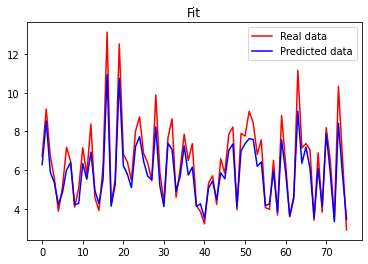

In [12]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [13]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.64
Coefficient of determination: 0.86
MAE:0.63
mean absolute percentage error:0.09


In [14]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [15]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 2.56
Coefficient of determination: 0.68
MAE:1.00
mean absolute percentage error:0.14


In [16]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs
)

In [17]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [18]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(X_train, y_train)

2022-01-15 08:55:30.504376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-15 08:55:30.504413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-15 08:55:30.525534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-15 08:55:30.525699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-01-15 08:55:30.562419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

In [19]:
warnings.filterwarnings("ignore")

In [20]:
# summarize grid search information
bestParams = searchResults.best_params_
bestParams

{'learnRate': 0.01,
 'hiddenLayerTwo': 128,
 'hiddenLayerThree': 32,
 'hiddenLayerOne': 64,
 'epochs': 20,
 'dropout': 0.2,
 'batch_size': 32}

In [21]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=bestParams['hiddenLayerOne'], hiddenLayerTwo=bestParams['hiddenLayerTwo'], 
                      hiddenLayerThree=bestParams['hiddenLayerThree'], dropout=bestParams['dropout'], 
                      learnRate=bestParams['learnRate'])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(X_train, y_train,
              batch_size=bestParams['batch_size'],
              epochs=bestParams['epochs'], verbose=0)

In [22]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Training Performance**

In [23]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [24]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.70
Coefficient of determination: 0.84
MAE:0.65
mean absolute percentage error:0.10


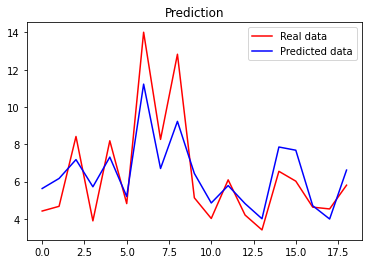

In [25]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [26]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 2.17
Coefficient of determination: 0.73
MAE:1.21
mean absolute percentage error:0.19


##### Using Vibrational Data only

In [27]:
used_features = ["clamp_t1", "clamp_t2", "clamp_t3", "clamp_t4", "clamp_t5", "clamp_t6", "clamp_t7", "clamp_t8", "clamp_t9",
                "clamp_f1", "clamp_f2", 
                "robot_t1", "robot_t2", "robot_t3", "robot_t4", "robot_t5", "robot_t6", "robot_t7", "robot_t8", "robot_t9",
                "robot_f1", "robot_f2"]

In [28]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data[used_features]
y = all_data["Ra_down"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

**Scaling**

In [30]:
s = StandardScaler()

In [31]:
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [32]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
input_dim = [22]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [33]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [34]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(X_train, y_train)

In [35]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [36]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [37]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Test Performance**

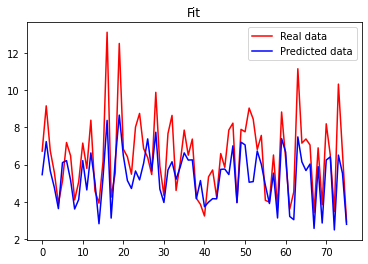

In [38]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [39]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.54
Coefficient of determination: 0.43
MAE:1.22
mean absolute percentage error:0.18


In [40]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [41]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.70
Coefficient of determination: 0.17
MAE:1.70
mean absolute percentage error:0.22


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 2

In [42]:
train_data = pd.read_csv("../data/feature_set2/down_train_data.csv")
train_data = train_data.drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("../data/feature_set2/down_test_data.csv")
test_data = test_data.drop(columns=["Unnamed: 0"])

In [43]:
train_data

feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
0    4.926693 -0.058744 -0.972788  1.146457 -0.745205  0.151388  0.653539   
1    4.505637 -2.453069 -1.849295 -0.068987 -1.471864  0.295033 -0.568436   
2    3.942451 -3.379427  1.033273  0.452020 -2.004696 -0.138028 -1.516452   
3    7.473127 -0.791705 -1.063846  4.192822  2.256821  1.748783 -1.141393   
4   -3.696640  3.700428 -2.346869 -1.768841  0.821928  0.070813 -1.663896   
..        ...       ...       ...       ...       ...       ...       ...   
71  -1.501138 -2.469852 -0.619027  0.128022 -1.115281 -0.071495  0.138404   
72  11.480630  2.291443  2.374967  1.131618  0.602096  1.742665  0.745685   
73  -3.411339 -1.247133 -0.958808  0.724197 -0.283831  1.879325  1.165289   
74   4.421632 -3.527195  0.813400 -0.593051  0.978230 -0.728910 -1.268248   
75   9.035175  4.343312  0.629074 -1.038790 -0.482011  0.365690  2.066108   

    feature7  feature8  feature9  ...  feature25  feature26  feature27  \
0  -0.824598  0.313122  1.431118  ...   0.058522  -0.126168  -0.176494   
1  -1.031699  0.703771  2.628536  ...  -0.208075  -0.056296  -0.453371   
2  -1.586873  0.436335  1.046757  ...  -0.124438  -0.079969  -0.154832   
3   0.252762  1.589721 -0.908058  ...  -0.088953   0.057311   0.099667   
4  -0.071293  0.761688 -1.165422  ...  -0.032334   0.387626  -0.332417   
..       ...       ...       ...  ...        ...        ...        ...   
71  0.757767 -0.397968 -0.227060  ...  -0.392936  -0.489447  -0.181481   
72  0.991329 -1.358764 -1.802182  ...   0.349495  -0.441188  -0.132840   
73 -0.035439 -0.547234 -0.194064  ...  -0.170497  -0.134336   0.265738   
74  0.281867 -1.452819 -0.211110  ...  -0.428755   0.067193   0.013812   
75  0.320282  0.549064 -1.395252  ...  -0.692949  -0.208290  -0.180998   

    feature28  feature29   Ra_down   ap   vbs  spindle_speed     fz  
0    0.174581  -0.199490   6.72425  1.0  1500          10000  0.075  
1    0.074664   0.167918   9.15850  1.0  1300          10000  0.065  
2    0.113511   0.007324   6.73350  0.8  1560          12000  0.065  
3    0.041628   0.074766   5.58375  0.8  2000          10000  0.100  
4    0.315494   0.013165   3.89050  0.4  2800          14000  0.100  
..        ...        ...       ...  ...   ...            ...    ...  
71  -0.209439   0.075472   6.51200  0.6  1040           8000  0.065  
72   0.373881   0.063317   3.47700  1.0  3200          16000  0.100  
73  -0.245462  -0.132593  10.32700  0.6  1000          10000  0.050  
74  -0.287154  -0.107976   6.64675  0.8  1600           8000  0.100  
75  -0.265513   0.501692   2.92575  0.8  3200          16000  0.100  

[76 rows x 35 columns]

##### Using all Features

In [44]:
x_train = train_data.drop(columns=["Ra_down"])
x_test = test_data.drop(columns=["Ra_down"])
y_train = train_data["Ra_down"].values
y_test = test_data["Ra_down"].values

In [45]:
input_dim = [x_train.shape[1]]

In [46]:
s = StandardScaler()

In [47]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [48]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [49]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [50]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [51]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [52]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [53]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

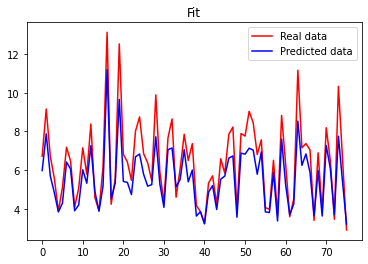

In [54]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [55]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.09
Coefficient of determination: 0.75
MAE:0.84
mean absolute percentage error:0.12


**Test Performance**

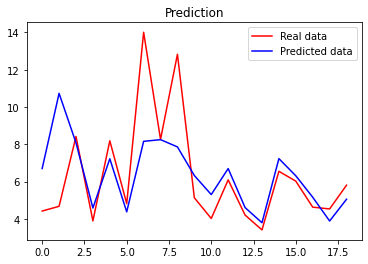

In [56]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [57]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.69
Coefficient of determination: 0.30
MAE:1.49
mean absolute percentage error:0.23


##### Using Vibrational Data only

In [58]:
x_train = train_data.drop(columns=["Ra_down", "ap", "fz", "spindle_speed", "vbs"])
x_test = test_data.drop(columns=["Ra_down", "ap", "fz", "spindle_speed", "vbs"])
y_train = train_data["Ra_down"].values
y_test = test_data["Ra_down"].values

In [59]:
input_dim = [x_train.shape[1]]

In [60]:
s = StandardScaler()

In [61]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [62]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [63]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [64]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [65]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [66]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [67]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

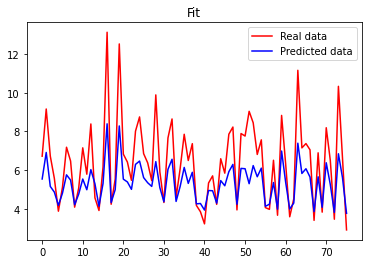

In [68]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [69]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.48
Coefficient of determination: 0.44
MAE:1.21
mean absolute percentage error:0.16


**Test Performance**

In [70]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [71]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 7.30
Coefficient of determination: 0.10
MAE:1.83
mean absolute percentage error:0.26


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 3

In [72]:
train_data = pd.read_csv("../data/feature_set3/down_train_data.csv")
test_data = pd.read_csv("../data/feature_set3/down_test_data.csv")

##### Using all Features

In [73]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_down"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_down"])
y_train = train_data["Ra_down"]
y_test = test_data["Ra_down"]

In [74]:
input_dim = [x_train.shape[1]]

In [75]:
s = StandardScaler()

In [76]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [77]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [78]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [79]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [80]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [81]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [82]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

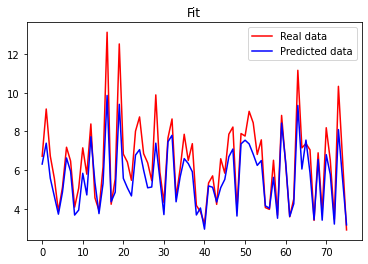

In [83]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [84]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.11
Coefficient of determination: 0.75
MAE:0.80
mean absolute percentage error:0.11


**Test Performance**

In [85]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [86]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 3.67
Coefficient of determination: 0.55
MAE:1.28
mean absolute percentage error:0.18


##### Using Vibrational Data only

In [87]:
x_train = train_data.drop(columns=["Ra_down", "spindle_speed", "vbs", "fz", "ap", "Unnamed: 0"])
y_train = train_data["Ra_down"]
x_test = test_data.drop(columns=["Ra_down", "spindle_speed", "vbs", "fz", "ap", "Unnamed: 0"])
y_test = test_data["Ra_down"]

In [88]:
input_dim = [x_train.shape[1]]

In [89]:
s = StandardScaler()

In [90]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [91]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [92]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [93]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [94]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [95]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [96]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

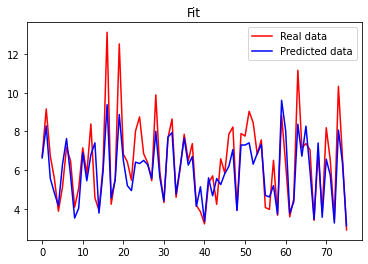

In [97]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [98]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.35
Coefficient of determination: 0.70
MAE:0.81
mean absolute percentage error:0.12


**Test Performance**

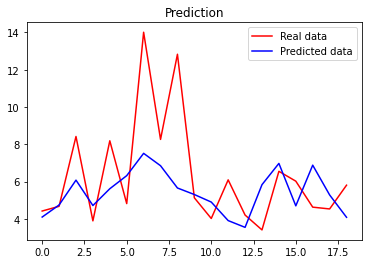

In [99]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [100]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 7.01
Coefficient of determination: 0.13
MAE:1.87
mean absolute percentage error:0.27


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

### ANN-Tests for Up Milling

#### Feature Set 1

##### Using all Features

In [101]:
warnings.filterwarnings("ignore")

**Trainings-Test-Split**

In [102]:
up_or_down = 'up' # or down
all_data = pd.read_csv('../data/feature_set1/train_{}_Y.csv'.format(up_or_down))
#all_data = pd.read_csv('../data/train_{}.csv'.format(up_or_down))
all_data.drop(index=[48, 49, 51, 72, 91], axis=0, inplace=True)  # drop outliers
all_data

Nr.  spindle_speed   ap     fz     Ra_up   vbs   clamp_t1       clamp_t2  \
0     1           8000  0.2  0.050  12.90500   800  26.229323    1295.769854   
1     2           8000  0.2  0.065   6.78175  1040  29.329545     994.685664   
2     3           8000  0.2  0.075   8.43450  1200  22.787313    1504.542610   
3     4           8000  0.2  0.100   6.77025  1600  28.397163    2118.802554   
4     5           8000  0.4  0.050  12.54250   800  43.666667     824.102151   
..  ...            ...  ...    ...       ...   ...        ...            ...   
95   96          16000  0.8  0.100   3.11025  3200  39.924444  160186.489802   
96   97          16000  1.0  0.050   5.85575  1600  25.689286   61144.222107   
97   98          16000  1.0  0.065   4.02725  2080   5.792453   95282.490852   
98   99          16000  1.0  0.075   3.47650  2400  14.818519  118458.498541   
99  100          16000  1.0  0.100   3.31500  3200   9.865741  173658.563286   

      clamp_t3  clamp_t4  ...  robot_t4  robot_t5  robot_t6  robot_t7  \
0    44.484558     155.0  ...    1210.0     384.0  0.295203  2.858728   
1    43.024878     128.0  ...    1221.0     454.0  0.129026  2.502421   
2    44.924273     151.0  ...    1246.0     474.0  0.202293  2.518253   
3    54.015627     169.0  ...    1278.0     614.0  0.179430  2.414027   
4    52.226146     126.0  ...    1128.0     311.0  0.169912  3.404943   
..         ...       ...  ...       ...       ...       ...       ...   
95  401.333416     713.0  ...    1535.0     939.0  0.579099  3.145979   
96  248.164843     449.0  ...    1489.0     778.0  0.697902  3.294399   
97  308.150104     505.0  ...    1568.0     974.0  0.622258  3.585680   
98  343.859494     594.0  ...    1671.0    1069.0  1.037621  4.416112   
99  415.874887     710.0  ...    1795.0    1246.0  0.952835  4.112866   

    robot_t8  robot_t9    clamp_f1   clamp_f2   robot_f1   robot_f2  
0   1.223420  1.219488   17.582900  21.717172  51.978762   5.050505  
1   1.249903  1.244343   15.763967  21.717172  45.485476   4.545455  
2   1.249318  1.243240   20.080109  21.717172  63.985078   5.050505  
3   1.287632  1.278015   20.092329  21.717172  84.466924   5.050505  
4   1.141053  1.139565   13.043699   9.595960  32.618295   6.060606  
..       ...       ...         ...        ...        ...        ...  
95  1.561329  1.531499  298.469357  21.212121  80.588421   5.050505  
96  1.498190  1.479387  201.613311  21.212121  73.910743  40.909091  
97  1.583423  1.557819  233.721883  21.212121  85.220207   4.545455  
98  1.690326  1.655686  287.327157  21.212121  94.816151   4.545455  
99  1.767508  1.723052  278.428731  21.212121  84.996157  40.909091  

[95 rows x 28 columns]

In [103]:
used_features = ["spindle_speed", "ap", "fz", "vbs", 
                 "clamp_t1", "clamp_t2", "clamp_t3", "clamp_t4", "clamp_t5", "clamp_t6", "clamp_t7", "clamp_t8", "clamp_t9",
                "clamp_f1", "clamp_f2", 
                "robot_t1", "robot_t2", "robot_t3", "robot_t4", "robot_t5", "robot_t6", "robot_t7", "robot_t8", "robot_t9",
                "robot_f1", "robot_f2"]

In [104]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data[used_features]
y = all_data["Ra_up"]

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

**Scaling**

In [106]:
s = StandardScaler()

In [107]:
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

**ANN - Definition and Training**

In [108]:
def get_mlp_model(hiddenLayerOne=64, hiddenLayerTwo=32, hiddenLayerThree=16,
    dropout=0.2, learnRate=0.01, input_dim=26):

    
    # Initialising the ANN
    model = Sequential()

    # Adding the input layer and the first hidden layer
    model.add(Dense(hiddenLayerOne, activation = 'relu', input_dim=input_dim))
    
    model.add(Dropout(dropout))
       
    # Adding the second hidden layer
    model.add(Dense(hiddenLayerTwo, activation='relu'))

    model.add(Dropout(dropout))

    # Adding the third hidden layer
    model.add(Dense(hiddenLayerThree, activation='relu'))

    # Adding the output layer
    model.add(Dense(units=1))

    #model.add(Dense(1))
    # Compiling the ANN
    model.compile(optimizer=Adam(learning_rate=learnRate), loss='mean_squared_error',)
    
    return model

In [109]:
# Fitting the ANN to the Training set
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model()
model.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)

In [110]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Training and Test Performance**

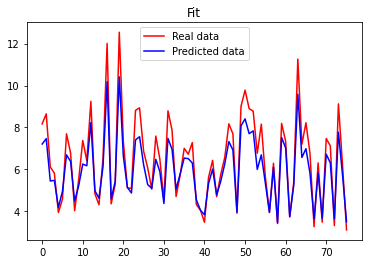

In [111]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [112]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.61
Coefficient of determination: 0.86
MAE:0.61
mean absolute percentage error:0.08


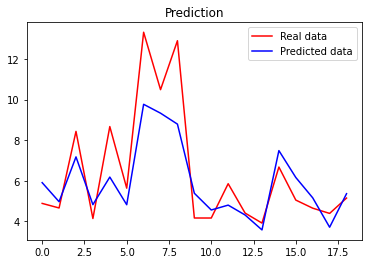

In [113]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [114]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 2.45
Coefficient of determination: 0.71
MAE:1.15
mean absolute percentage error:0.16


In [115]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs
)

In [116]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [117]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(X_train, y_train)

In [118]:
# summarize grid search information
bestParams = searchResults.best_params_
bestParams

{'learnRate': 0.01,
 'hiddenLayerTwo': 128,
 'hiddenLayerThree': 4,
 'hiddenLayerOne': 32,
 'epochs': 100,
 'dropout': 0.4,
 'batch_size': 16}

In [119]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=128, hiddenLayerTwo=32, hiddenLayerThree=16, dropout=0.3, learnRate=0.01)
# train the network (i.e., no hyperparameter tuning)
H = model.fit(X_train, y_train,
              batch_size=64,
              epochs=40, verbose=0)

In [120]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Training Performance**

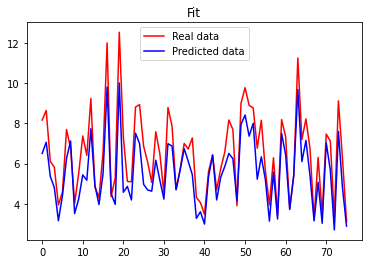

In [121]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [122]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.34
Coefficient of determination: 0.68
MAE:0.96
mean absolute percentage error:0.14


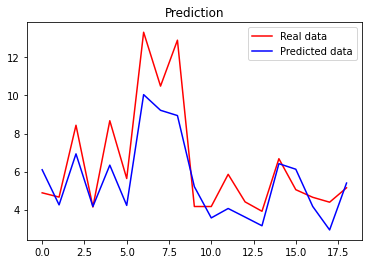

In [123]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [124]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 2.58
Coefficient of determination: 0.69
MAE:1.26
mean absolute percentage error:0.19


##### Using Vibrational Data only

In [125]:
used_features = ["clamp_t1", "clamp_t2", "clamp_t3", "clamp_t4", "clamp_t5", "clamp_t6", "clamp_t7", "clamp_t8", "clamp_t9",
                "clamp_f1", "clamp_f2", 
                "robot_t1", "robot_t2", "robot_t3", "robot_t4", "robot_t5", "robot_t6", "robot_t7", "robot_t8", "robot_t9",
                "robot_f1", "robot_f2"]

In [126]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data[used_features]
y = all_data["Ra_up"]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

**Scaling**

In [128]:
s = StandardScaler()

In [129]:
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [130]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
input_dim = [22]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [131]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [132]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(X_train, y_train)

In [133]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [134]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [135]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)

**Test Performance**

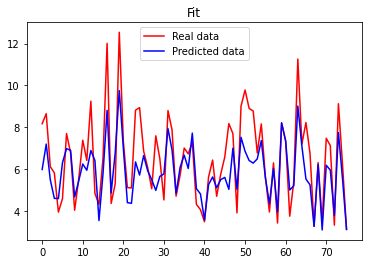

In [136]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [137]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.78
Coefficient of determination: 0.58
MAE:1.00
mean absolute percentage error:0.15


In [138]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [139]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.91
Coefficient of determination: 0.17
MAE:1.65
mean absolute percentage error:0.20


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 2

In [140]:
train_data = pd.read_csv("../data/feature_set2/up_train_data.csv")
train_data = train_data.drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("../data/feature_set2/up_test_data.csv")
test_data = test_data.drop(columns=["Unnamed: 0"])

In [141]:
train_data

0         1         2         3         4         5         6  \
0    5.945274  2.946182  0.149473 -2.099254 -1.787817 -0.476360  0.602542   
1    6.870735  4.451790 -0.461032 -2.010468 -0.070494  0.298283  0.183453   
2    3.047654  2.845488 -3.892184 -0.726106 -0.556185  0.030895 -0.122298   
3    6.868730  0.460162 -1.842556  0.062080 -2.429456  0.137089 -2.845331   
4   -3.107728 -3.925702  1.849473 -2.165281  0.469393 -0.426845  1.010382   
..        ...       ...       ...       ...       ...       ...       ...   
71  -2.924905  2.933416  4.847481  1.315622 -0.006010  0.149245  0.390996   
72  15.511797 -3.067967  1.392928  3.226637  6.246290 -0.628106 -2.340565   
73  -2.736577  1.493409  0.835664 -0.412348 -0.060097 -1.098867 -1.492672   
74  -0.601152  1.031921  1.571812  1.212296  0.788578  1.542904  1.335956   
75  11.048979 -3.757394 -0.007926  0.483363 -1.910653 -0.448840 -0.172619   

           7         8         9  ...        25        26        27        28  \
0  -0.085961  1.814742  0.473429  ... -0.435935 -0.378838 -0.196685 -0.135519   
1   0.122228  2.006589 -0.472541  ... -0.100021  0.041602  0.088858 -0.162832   
2   0.433306 -1.232217  0.223748  ...  0.425064 -0.123533 -0.006671  0.095613   
3   1.520199 -1.393819 -2.525601  ... -0.162768 -0.060219  0.136893 -0.024405   
4   0.081257  0.309712  0.207686  ... -0.366783 -0.031313  0.194916 -0.015383   
..       ...       ...       ...  ...       ...       ...       ...       ...   
71  0.150057  0.237324 -0.785805  ...  0.284887  0.084803 -0.164260  0.166958   
72 -0.590445 -0.752094 -0.649529  ... -0.068147  0.088425  0.062391 -0.157370   
73 -0.442616  0.221887  0.188602  ... -0.387399  0.152418  0.270183 -0.088166   
74 -0.986682  0.485984 -1.684684  ... -0.237579  0.069487  0.046799  0.071759   
75 -1.297819  1.476787 -0.117532  ...  0.774600  0.161141 -0.270055 -0.325127   

          29    Ra_up   ap   vbs  spindle_speed     fz  
0  -0.017322  8.16800  1.0  1500          10000  0.075  
1   0.046739  8.64725  1.0  1300          10000  0.065  
2  -0.050169  6.11125  0.8  1560          12000  0.065  
3  -0.095647  5.81925  0.8  2000          10000  0.100  
4  -0.087354  3.94125  0.4  2800          14000  0.100  
..       ...      ...  ...   ...            ...    ...  
71  0.175883  7.12000  0.6  1040           8000  0.065  
72  0.037909  3.31500  1.0  3200          16000  0.100  
73  0.006111  9.12300  0.6  1000          10000  0.050  
74  0.065973  6.24950  0.8  1600           8000  0.100  
75 -0.246311  3.11025  0.8  3200          16000  0.100  

[76 rows x 35 columns]

##### Using all Features

In [142]:
x_train = train_data.drop(columns=["Ra_up"])
x_test = test_data.drop(columns=["Ra_up"])
y_train = train_data["Ra_up"].values
y_test = test_data["Ra_up"].values

In [143]:
input_dim = [x_train.shape[1]]

In [144]:
s = StandardScaler()

In [145]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [146]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [147]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [148]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [149]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [150]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [151]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

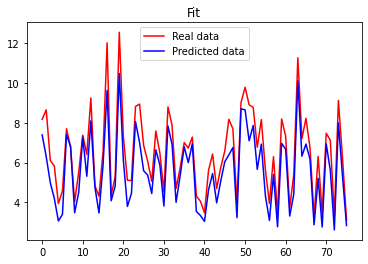

In [152]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [153]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.03
Coefficient of determination: 0.76
MAE:0.89
mean absolute percentage error:0.14


**Test Performance**

In [154]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [155]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 11.25
Coefficient of determination: -0.35
MAE:2.32
mean absolute percentage error:0.38


##### Using Vibrational Data only

In [156]:
x_train = train_data.drop(columns=["Ra_up", "ap", "fz", "spindle_speed", "vbs"])
x_test = test_data.drop(columns=["Ra_up", "ap", "fz", "spindle_speed", "vbs"])
y_train = train_data["Ra_up"].values
y_test = test_data["Ra_up"].values

In [157]:
input_dim = [x_train.shape[1]]

In [158]:
s = StandardScaler()

In [159]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [160]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [161]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [162]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [163]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [164]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [165]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

In [166]:
plt.plot(y_train, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [167]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.14
Coefficient of determination: 0.50
MAE:1.15
mean absolute percentage error:0.15


**Test Performance**

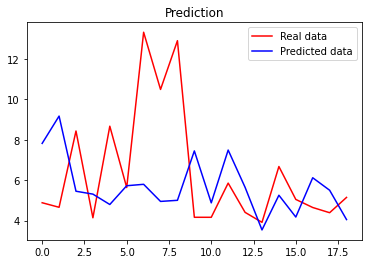

In [168]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [169]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 11.95
Coefficient of determination: -0.43
MAE:2.62
mean absolute percentage error:0.38


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Feature Set 3

In [170]:
train_data = pd.read_csv("../data/feature_set3/up_train_data.csv")
test_data = pd.read_csv("../data/feature_set3/up_test_data.csv")

##### Using all Features

In [171]:
x_train = train_data.drop(columns=["Unnamed: 0", "Ra_up"])
x_test = test_data.drop(columns=["Unnamed: 0", "Ra_up"])
y_train = train_data["Ra_up"]
y_test = test_data["Ra_up"]

In [172]:
input_dim = [x_train.shape[1]]

In [173]:
s = StandardScaler()

In [174]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [175]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [176]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [177]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [178]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [179]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [180]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

In [181]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [182]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 1.26
Coefficient of determination: 0.70
MAE:0.83
mean absolute percentage error:0.11


**Test Performance**

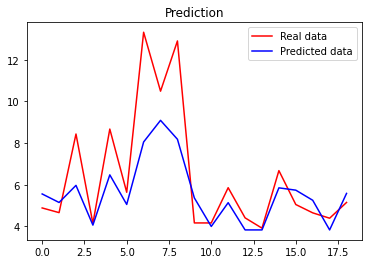

In [183]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [184]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 3.60
Coefficient of determination: 0.57
MAE:1.25
mean absolute percentage error:0.16


##### Using Vibrational Data only

In [185]:
x_train = train_data.drop(columns=["spindle_speed", "vbs", "Ra_up", "fz", "ap", "Unnamed: 0"])
x_test = test_data.drop(columns=["spindle_speed", "vbs", "Ra_up", "fz", "ap", "Unnamed: 0"])
y_train = train_data["Ra_up"]
y_test = test_data["Ra_up"]

In [186]:
input_dim = [x_train.shape[1]]

In [187]:
s = StandardScaler()

In [188]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [189]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [190]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [191]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [192]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [193]:
SEED = 20
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [194]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

In [195]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [196]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.18
Coefficient of determination: 0.49
MAE:1.01
mean absolute percentage error:0.14


**Test Performance**

In [197]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [198]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 5.98
Coefficient of determination: 0.28
MAE:1.61
mean absolute percentage error:0.21


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Test with all Vibrational Data

In [174]:
up_or_down = 'down' # or down
all_data = pd.read_csv('../data/train_{}.csv'.format(up_or_down))
#all_data = pd.read_csv('../data/train_{}.csv'.format(up_or_down))
#all_data.drop(index=[48, 49, 51, 72, 91], axis=0, inplace=True)  # drop outliers
all_data

Nr.  spindle_speed   ap     fz   Ra_down   vbs   clamp_X_t1    clamp_X_t2  \
0     1           8000  0.2  0.050  12.83250   800  1006.922780    540.714944   
1     2           8000  0.2  0.065   6.47625  1040  1011.200000    495.153285   
2     3           8000  0.2  0.075   8.42100  1200  1010.478088   1183.394518   
3     4           8000  0.2  0.100   6.81600  1600  1014.856604   1849.752087   
4     5           8000  0.4  0.050  12.51250   800  1012.252033    307.364792   
..  ...            ...  ...    ...       ...   ...          ...           ...   
90   96          16000  0.8  0.100   2.92575  3200  1011.086364  57690.316708   
91   97          16000  1.0  0.050   6.09400  1600  1012.458955  30946.496436   
92   98          16000  1.0  0.065   4.09975  2080  1012.382900  43796.558065   
93   99          16000  1.0  0.075   3.23825  2400  1008.424084  60070.456048   
94  100          16000  1.0  0.100   3.47700  3200  1017.457711  68878.569453   

     clamp_X_t3  clamp_X_t4  ...  robot_Z_t4  robot_Z_t5  robot_Z_t6  \
0   1007.190206      1069.0  ...        81.0       244.0   -0.082819   
1   1011.443915      1073.0  ...        81.0       267.0   -0.193778   
2   1011.061148      1098.0  ...       203.0       402.0    0.233182   
3   1015.764096      1149.0  ...       172.0       384.0   -0.014634   
4   1012.403226      1054.0  ...        96.0       235.0    0.071085   
..          ...         ...  ...         ...         ...         ...   
90  1039.097552      1387.0  ...       379.0       731.0    0.305023   
91  1027.571973      1272.0  ...       338.0       764.0    0.114655   
92  1033.708315      1357.0  ...       386.0       765.0    0.303215   
93  1037.629550      1348.0  ...       394.0       726.0    0.286188   
94  1050.597965      1386.0  ...       455.0       879.0    0.125279   

    robot_Z_t7  robot_Z_t8  robot_Z_t9  clamp_Z_f1  clamp_Z_f2  robot_Z_f1  \
0     0.033106    3.152414    3.954053   15.645704    9.595960   14.352017   
1    -0.045910    3.073618    3.778982   12.539378    9.595960   21.778924   
2     1.098980    3.390257    4.381552   13.575457    9.595960   29.323713   
3     0.450152    3.212870    4.072230   25.499032   10.101010   26.585129   
4    -0.309127    2.531721    3.149854   11.267483    9.595960   33.800351   
..         ...         ...         ...         ...         ...         ...   
90   -0.133957    2.511126    3.084951   20.555727   21.717172   53.179353   
91   -0.172974    3.309441    3.978185   17.364079   21.212121   55.947780   
92   -0.511555    2.433086    2.943668   20.392808   21.212121   52.036968   
93   -0.129468    2.591390    3.288346   61.266221    0.505051   54.902098   
94   -0.357987    2.314565    2.890481   22.823974   21.212121   65.798832   

    robot_Z_f2  
0    16.161616  
1     4.545455  
2     5.050505  
3    16.666667  
4     6.060606  
..         ...  
90   40.909091  
91   40.909091  
92   19.696970  
93   19.696970  
94   19.696970  

[95 rows x 72 columns]

In [175]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data.drop(["Nr.", "Ra_down", "spindle_speed", "vbs", "fz", "ap"], axis=1)
y = all_data["Ra_down"]

In [176]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

In [177]:
input_dim = [x_train.shape[1]]

**Scaling**

In [178]:
s = StandardScaler()

In [179]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [180]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [181]:
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [182]:
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [183]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [184]:
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [185]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

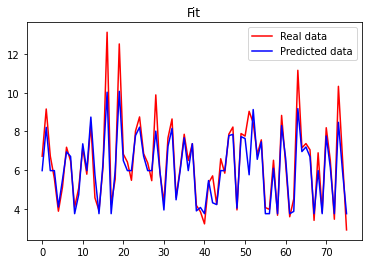

In [186]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [187]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 0.68
Coefficient of determination: 0.85
MAE:0.53
mean absolute percentage error:0.08


**Test Performance**

In [188]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [189]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.28
Coefficient of determination: 0.22
MAE:1.68
mean absolute percentage error:0.24


**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

**##########################################################################################**

#### Test with Magnitude Data

In [190]:
up_or_down = 'down' # or down
all_data = pd.read_csv('../data/train_{}_m.csv'.format(up_or_down))
#all_data = pd.read_csv('../data/train_{}.csv'.format(up_or_down))
all_data.drop(index=[48, 49, 51, 72, 91], axis=0, inplace=True)  # drop outliers
all_data

Nr.  spindle_speed   ap     fz   Ra_down   vbs     clamp_t1      clamp_t2  \
0     1           8000  0.2  0.050  12.83250   800  1007.867588    538.672008   
1     2           8000  0.2  0.065   6.47625  1040  1012.637944    506.107625   
2     3           8000  0.2  0.075   8.42100  1200  1012.394397   1152.871020   
3     4           8000  0.2  0.100   6.81600  1600  1017.842300   1821.636726   
4     5           8000  0.4  0.050  12.51250   800  1013.913929    289.403132   
..  ...            ...  ...    ...       ...   ...          ...           ...   
95   96          16000  0.8  0.100   2.92575  3200  1072.332971  59709.072276   
96   97          16000  1.0  0.050   6.09400  1600  1037.714512  32188.034727   
97   98          16000  1.0  0.065   4.09975  2080  1053.294987  47267.170098   
98   99          16000  1.0  0.075   3.23825  2400  1055.197427  61071.738510   
99  100          16000  1.0  0.100   3.47700  3200  1079.383396  76387.167363   

       clamp_t3     clamp_t4  ...     robot_t4    robot_t5  robot_t6  \
0   1008.133755  1070.245766  ...  1161.079670  328.223740 -0.168661   
1   1012.886900  1075.324137  ...  1127.102923  254.409392  0.097864   
2   1012.961348  1098.382902  ...  1207.733828  315.140416  0.258451   
3   1018.733385  1149.941738  ...  1209.320884  377.822838  0.095736   
4   1014.056055  1055.218461  ...  1171.072158  282.844147  0.162400   
..          ...          ...  ...          ...         ...       ...   
95  1099.697990  1480.682275  ...  1514.487372  842.953307  0.306488   
96  1053.052392  1304.290612  ...  1473.829705  791.322562  0.008762   
97  1075.417028  1393.146798  ...  1452.901235  811.879395  0.013894   
98  1083.602142  1396.332339  ...  1439.462052  779.931158  0.039590   
99  1114.035748  1457.450171  ...  1562.508880  972.771650  0.080852   

    robot_t7  robot_t8  robot_t9    clamp_f1   clamp_f2   robot_f1   robot_f2  
0   0.365019  1.142297  1.143824    7.909184   9.595960  22.046694  14.646465  
1  -0.091280  1.113552  1.114875   11.566222  21.717172  20.396311  31.313131  
2  -0.115431  1.189614  1.191337   13.345692   9.595960  29.167102  31.313131  
3  -0.233515  1.191020  1.193704   23.289115  10.101010  31.499120   5.050505  
4  -0.313465  1.152996  1.154718   11.238603  21.717172  30.672898   6.060606  
..       ...       ...       ...         ...        ...        ...        ...  
95 -0.472250  1.432629  1.456928  158.936620  21.717172  59.372309  40.909091  
96 -0.662970  1.402078  1.420403  140.886490  21.212121  66.352249  40.909091  
97 -0.779065  1.361992  1.384491  164.432149  21.212121  84.790331  38.383838  
98 -0.254460  1.373958  1.392068  146.690129  21.212121  71.416023  40.909091  
99 -0.633181  1.434471  1.464439  181.331652  21.212121  67.870641  47.474747  

[95 rows x 28 columns]

In [191]:
#X = df.drop(["Nr.", "Ra_down"], axis=1)
X = all_data.drop(["Nr.", "Ra_down", "spindle_speed", "vbs", "fz", "ap"], axis=1)
y = all_data["Ra_down"]

In [192]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

In [193]:
input_dim = [x_train.shape[1]]

**Scaling**

In [194]:
s = StandardScaler()

In [195]:
x_train = s.fit_transform(x_train)
x_test = s.transform(x_test)

In [196]:
# define a grid of the hyperparameter search space
hiddenLayerOne = [16, 32, 64, 128, 256]
hiddenLayerTwo = [8, 16, 32, 64, 128]
hiddenLayerThree = [4, 8, 16, 32, 64]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2, 0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32, 64, 128]
epochs = [10, 20, 30, 40, 50, 100, 200, 500]
# create a dictionary from the hyperparameter grid
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    hiddenLayerTwo=hiddenLayerTwo,
    hiddenLayerThree=hiddenLayerThree,
    dropout=dropout,
    batch_size=batchSize,
    epochs=epochs,
    input_dim=input_dim
)

In [197]:
model = KerasRegressor(build_fn=get_mlp_model, verbose=0)

In [198]:
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=5,
                              param_distributions=grid, scoring="neg_mean_absolute_error", n_iter=100, random_state=20)
searchResults = searcher.fit(x_train, y_train)

In [199]:
# summarize grid search information
bestParams = searchResults.best_params_
hiddenLayerOne = bestParams['hiddenLayerOne']
hiddenLayerTwo = bestParams['hiddenLayerTwo']
hiddenLayerThree = bestParams['hiddenLayerThree']
epochs = bestParams['epochs']
dropout = bestParams['dropout']
batch_size = bestParams['batch_size']
learnRate = bestParams['learnRate']

In [200]:
model = get_mlp_model(hiddenLayerOne=hiddenLayerOne, hiddenLayerTwo=hiddenLayerTwo, 
                      hiddenLayerThree=hiddenLayerThree, dropout=dropout, learnRate=learnRate, input_dim=input_dim[0])
# train the network (i.e., no hyperparameter tuning)
H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, verbose=0)

In [201]:
y_fit = model.predict(x_train)
y_pred = model.predict(x_test)

**Training Performance**

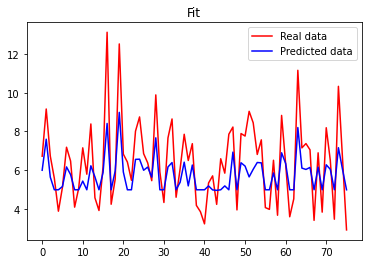

In [202]:
plt.plot(y_train.values, color = 'red', label = 'Real data')
plt.plot(y_fit, color = 'blue', label = 'Predicted data')
plt.title('Fit')
plt.legend()

In [203]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, y_fit))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_fit))
print('MAE:%.2f'
      % mean_absolute_error(y_train, y_fit))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_train, y_fit))

Mean squared error: 2.30
Coefficient of determination: 0.48
MAE:1.25
mean absolute percentage error:0.20


**Test Performance**

In [204]:
plt.plot(y_test.values, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()

In [205]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('MAE:%.2f'
      % mean_absolute_error(y_test, y_pred))
print('mean absolute percentage error:%.2f'
     % mean_absolute_percentage_error(y_test,y_pred))

Mean squared error: 6.66
Coefficient of determination: 0.18
MAE:1.78
mean absolute percentage error:0.24
